<a href="https://colab.research.google.com/github/manargani/VOICE-CLONING/blob/main/Demo1f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from pathlib import Path

repo_dir = Path("OpenVoice")

if not repo_dir.exists():
    !git clone https://github.com/myshell-ai/OpenVoice
    orig_english_path = Path("OpenVoice/openvoice/text/_orig_english.py")
    english_path = Path("OpenVoice/openvoice/text/english.py")

    english_path.rename(orig_english_path)

    with orig_english_path.open("r") as f:
        data = f.read()
        data = data.replace("unidecode", "anyascii")
        with english_path.open("w") as out_f:
            out_f.write(data)
# append to sys.path so that modules from the repo could be imported
sys.path.append(str(repo_dir))

%pip install -q "librosa>=0.8.1" "wavmark>=0.0.3" "faster-whisper>=0.9.0" "pydub>=0.25.1" "whisper-timestamped>=1.14.2" "tqdm" "inflect>=7.0.0" "eng_to_ipa>=0.0.2" "pypinyin>=0.50.0" \
"cn2an>=0.5.22" "jieba>=0.42.1" "langid>=1.1.6" "gradio>=4.15" "ipywebrtc" "anyascii" "openvino>=2023.3"

Cloning into 'OpenVoice'...
remote: Enumerating objects: 438, done.
remote: Total 438 (delta 0), reused 0 (delta 0), pack-reused 438 (from 1)
Receiving objects: 100% (438/438), 3.84 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (207/207), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 40.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4

In [ ]:
import os
import torch
import openvino as ov
import ipywidgets as widgets
from IPython.display import Audio
import librosa  # for audio analysis
import numpy as np  # for numerical operations
from scipy.io import wavfile  # for reading wav files
from sklearn.metrics import mean_squared_error  # for WER calculations
from typing import Tuple
import matplotlib.pyplot as plt  # for visualization

core = ov.Core()

from openvoice.api import BaseSpeakerTTS, ToneColorConverter, OpenVoiceBaseClass
import openvoice.se_extractor as se_extractor

In [ ]:
CKPT_BASE_PATH = 'checkpoints'

en_suffix = f'{CKPT_BASE_PATH}/base_speakers/EN'
zh_suffix = f'{CKPT_BASE_PATH}/base_speakers/ZH'
converter_suffix = f'{CKPT_BASE_PATH}/converter'

In [ ]:
enable_chinese_lang = False

In [ ]:
def download_from_hf_hub(filename, local_dir='./'):
    from huggingface_hub import hf_hub_download
    os.makedirs(local_dir, exist_ok=True)
    hf_hub_download(repo_id="myshell-ai/OpenVoice", filename=filename, local_dir=local_dir)

download_from_hf_hub(f'{converter_suffix}/checkpoint.pth')
download_from_hf_hub(f'{converter_suffix}/config.json')
download_from_hf_hub(f'{en_suffix}/checkpoint.pth')
download_from_hf_hub(f'{en_suffix}/config.json')

download_from_hf_hub(f'{en_suffix}/en_default_se.pth')
download_from_hf_hub(f'{en_suffix}/en_style_se.pth')

if enable_chinese_lang:
    download_from_hf_hub(f'{zh_suffix}/checkpoint.pth')
    download_from_hf_hub(f'{zh_suffix}/config.json')
    download_from_hf_hub(f'{zh_suffix}/zh_default_se.pth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


checkpoint.pth:   0%|          | 0.00/131M [00:00<?, ?B/s]

checkpoints/converter/config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

checkpoint.pth:   0%|          | 0.00/160M [00:00<?, ?B/s]

checkpoints/base_speakers/EN/config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

en_default_se.pth:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

en_style_se.pth:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

In [ ]:
pt_device = "cpu"

en_base_speaker_tts = BaseSpeakerTTS(f'{en_suffix}/config.json', device=pt_device)
en_base_speaker_tts.load_ckpt(f'{en_suffix}/checkpoint.pth')

tone_color_converter = ToneColorConverter(f'{converter_suffix}/config.json', device=pt_device)
tone_color_converter.load_ckpt(f'{converter_suffix}/checkpoint.pth')

if enable_chinese_lang:
    zh_base_speaker_tts = BaseSpeakerTTS(f'{zh_suffix}/config.json', device=pt_device)
    zh_base_speaker_tts.load_ckpt(f'{zh_suffix}/checkpoint.pth')
else:
    zh_base_speaker_tts = None

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/content/OpenVoice/openvoice/api.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

Loaded checkpoint 'checkpoints/base_speakers/EN/checkpoint.pth'
missing/unexpected keys: [] []


(…)BERP_none0.30_mean1.81_std1.81.model.pkl:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

Loaded checkpoint 'checkpoints/converter/checkpoint.pth'
missing/unexpected keys: [] []


/usr/local/lib/python3.10/dist-packages/wavmark/__init__.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume_path, map_location=torch.device(

In [ ]:
source_se = torch.load(f'{en_suffix }/en_default_se.pth').to(pt_device)

<ipython-input-7-ed08dc2ab8e8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_se = torch.load(f'{en_suffix }/en_default_se.pth').to(pt_device)


In [ ]:
reference_speaker = '/content/OpenVoice/resources/demo_speaker1.mp3' # This is the voice you want to clone

In [ ]:
target_se, audio_name = se_extractor.get_se(reference_speaker, tone_color_converter, target_dir='processed', vad=True)

OpenVoice version: v1


/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


[(0.174, 2.706), (3.502, 7.634), (9.71, 12.978), (14.83, 16.85), (17.518, 20.082), (24.654, 26.162), (33.614, 40.498), (45.486, 54.45), (55.534, 57.426), (59.758, 61.042), (74.446, 78.162)]
after vad: dur = 38.76401360544218


/usr/local/lib/python3.10/dist-packages/torch/functional.py:666: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [ ]:
OUTPUT_DIR = 'outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
save_path = f'{OUTPUT_DIR}/output_en_default.wav'

# Run the base speaker tts
text = "Hello it's Manar and I'm very happy to be part of the Mitacs Program."
src_path = f'{OUTPUT_DIR}/tmp.wav'
en_base_speaker_tts.tts(text, src_path, speaker='default', language='English', speed=1.0)

# Run the tone color converter
encode_message = "@MyShell"
tone_color_converter.convert(
    audio_src_path=src_path,
    src_se=source_se,
    tgt_se=target_se,
    output_path=save_path,
    message=encode_message)

 > Text splitted to sentences.
Hello it's Manar and I'm very happy to be part of the Mitacs Program.
 > ===========================
hɛˈloʊ ɪts manaɹ* ənd əm ˈvɛɹi ˈhæpi tɪ bi pɑɹt əv ðə mitacs* ˈpɹoʊˌgɹæm.
 length:73
 length:72


In [ ]:
source_se = torch.load(f'{en_suffix }/en_style_se.pth').to(pt_device)
save_path = f'{OUTPUT_DIR}/outputt_cheerful.wav'

# Run the base speaker tts
text = "Hello it's Manar and I'm very happy to be part of the Mitacs Program."
src_path = f'{OUTPUT_DIR}/tmp.wav'
en_base_speaker_tts.tts(text, src_path, speaker='cheerful', language='English', speed=0.9)

# Run the tone color converter
encode_message = "@MyShell"
tone_color_converter.convert(
    audio_src_path=src_path,
    src_se=source_se,
    tgt_se=target_se,
    output_path=save_path,
    message=encode_message)

<ipython-input-12-c99d1d2c9895>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_se = torch.load(f'{en_suffix }/en_style_se.pth').to(pt_device)


 > Text splitted to sentences.
Hello it's Manar and I'm very happy to be part of the Mitacs Program.
 > ===========================
hɛˈloʊ ɪts manaɹ* ənd əm ˈvɛɹi ˈhæpi tɪ bi pɑɹt əv ðə mitacs* ˈpɹoʊˌgɹæm.
 length:73
 length:72


In [ ]:
enable_chinese_lang = True

In [ ]:
CKPT_BASE_PATH= '/content/checkpoints/base_speakers/ZH'
en_base_speaker_tts = BaseSpeakerTTS(f'{CKPT_BASE_PATH}/config.json', device=pt_device)
en_base_speaker_tts.load_ckpt(f'{en_suffix}/checkpoint.pth')

source_se = torch.load(f'{CKPT_BASE_PATH}/zh_default_se.pth').to(pt_device)
save_path = f'{OUTPUT_DIR}/output3_chinese.wav'

# Run the base speaker tts
text = "你好，我是 马纳尔 "
src_path = f'{OUTPUT_DIR}/tmp.wav'
en_base_speaker_tts.tts(text, src_path, speaker='default', language='Chinese', speed=1.0)

# Run the tone color converter
encode_message = "@MyShell"
tone_color_converter.convert(
    audio_src_path=src_path,
    src_se=source_se,
    tgt_se=target_se,
    output_path=save_path,
    message=encode_message)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/content/OpenVoice/openvoice/api.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

Loaded checkpoint 'checkpoints/base_speakers/EN/checkpoint.pth'
missing/unexpected keys: [] []
 > Text splitted to sentences.
你好, 我是 马纳尔
 > ===========================


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.726 seconds.
DEBUG:jieba:Loading model cost 0.726 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


ni↓↑xɑʊ↓↑,  wo↓↑ s`ɹ`↓  ma↓↑na↓əɹ`↓↑.
 length:37
 length:37
Audio too short, fail to add watermark


In [ ]:
from IPython.display import Audio, display

reference_audio = '/content/OpenVoice/resources/demo_speaker1.mp3'
english_cheerful = f'{OUTPUT_DIR}/outputt_cheerful.wav'
english_default = f'{OUTPUT_DIR}/output_en_default.wav'
chinese_default = f'{OUTPUT_DIR}/output3_chinese.wav'


print("Playing reference speaker audio:")
display(Audio(reference_audio))

print("Playing english_default audio:")

display(Audio(english_default))

print("Playing english_cheerful audio:")

display(Audio(english_cheerful))

print("Playing chinese_default audio:")

display(Audio(chinese_default))


Playing reference speaker audio:


Playing english_default audio:


Playing english_cheerful audio:


Playing chinese_default audio:


In [ ]:
def calculate_mos(audio_path: str, reference_path: str) -> float:
    """Calculates Mean Opinion Score (MOS) based on user ratings."""
    # For a realistic application, you'd collect user ratings through a survey.
    return np.random.uniform(3.0, 5.0)  # Simulating MOS scores between 3.0 and 5.0

def calculate_snr(clean_audio_path: str, noisy_audio_path: str) -> float:
    """Calculates Signal-to-Noise Ratio (SNR)."""
    # Read the audio files
    sr1, clean_audio = wavfile.read(clean_audio_path)
    sr2, noisy_audio = wavfile.read(noisy_audio_path)

    # Ensure both audio files have the same sample rate
    assert sr1 == sr2, "Sample rates do not match!"

    # Pad the shorter array with zeros
    if len(clean_audio) > len(noisy_audio):
        noise = np.concatenate([noisy_audio, np.zeros(len(clean_audio) - len(noisy_audio))])
        clean_audio = clean_audio  # No change needed
    else:
        clean_audio = np.concatenate([clean_audio, np.zeros(len(noisy_audio) - len(clean_audio))])
        noise = noisy_audio  # No change needed

    # Calculate SNR
    noise = noise - clean_audio
    snr = 10 * np.log10(np.sum(clean_audio**2) / np.sum(noise**2))
    return snr

def calculate_wer(reference: str, hypothesis: str) -> float:
    """Calculates Word Error Rate (WER)."""
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
    for i in range(len(ref_words) + 1):
        d[i][0] = i
    for j in range(len(hyp_words) + 1):
        d[0][j] = j

    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i - 1] == hyp_words[j - 1] else 1
            d[i][j] = min(d[i - 1][j] + 1,      # Deletion
                           d[i][j - 1] + 1,      # Insertion
                           d[i - 1][j - 1] + cost)  # Substitution

    return d[len(ref_words)][len(hyp_words)] / len(ref_words)

# Perform benchmarking
reference_text = text  # Text used for generating audio
hypothesis_text = "Hello it's Manar and I'm very happy to be part of the Mitacs Program."  # Simulated output from ASR or similar system

mos_score = calculate_mos(save_path, src_path)  # Compare generated audio with a reference
snr_value = calculate_snr(src_path, save_path)  # Clean audio vs. generated audio
wer_value = calculate_wer(reference_text, hypothesis_text)  # Reference text vs. generated text

# Print benchmarking results
print(f"MOS Score: {mos_score:.2f}")
print(f"SNR Value: {snr_value:.2f} dB")
print(f"WER Value: {wer_value:.2f}")

MOS Score: 4.08
SNR Value: -37.93 dB
WER Value: 7.00


In [ ]:
def interpret_results(mos: float, snr: float, wer: float) -> None:
    """Interprets the benchmarking results."""
    print("\n--- Benchmarking Results Interpretation ---")

    # Interpret MOS
    if mos >= 4.5:
        print("MOS Score Interpretation: Excellent quality. Users will likely be very satisfied.")
    elif 4.0 <= mos < 4.5:
        print("MOS Score Interpretation: Good quality. Most users will likely be satisfied.")
    elif 3.0 <= mos < 4.0:
        print("MOS Score Interpretation: Fair quality. Some users may find it acceptable.")
    else:
        print("MOS Score Interpretation: Poor quality. Users are likely to be dissatisfied.")

    # Interpret SNR
    if snr > 20:
        print("SNR Interpretation: Excellent separation between signal and noise.")
    elif 10 < snr <= 20:
        print("SNR Interpretation: Acceptable separation between signal and noise.")
    else:
        print("SNR Interpretation: Poor separation between signal and noise; improvements needed.")

    # Interpret WER
    if wer == 0:
        print("WER Interpretation: Perfect transcription; no errors.")
    elif wer < 0.1:
        print("WER Interpretation: Low error rate; high accuracy.")
    elif 0.1 <= wer < 0.3:
        print("WER Interpretation: Moderate error rate; some improvement needed.")
    else:
        print("WER Interpretation: High error rate; significant improvements required.")

# Call the interpretation function
interpret_results(mos_score, snr_value, wer_value)


--- Benchmarking Results Interpretation ---
MOS Score Interpretation: Good quality. Most users will likely be satisfied.
SNR Interpretation: Poor separation between signal and noise; improvements needed.
WER Interpretation: High error rate; significant improvements required.


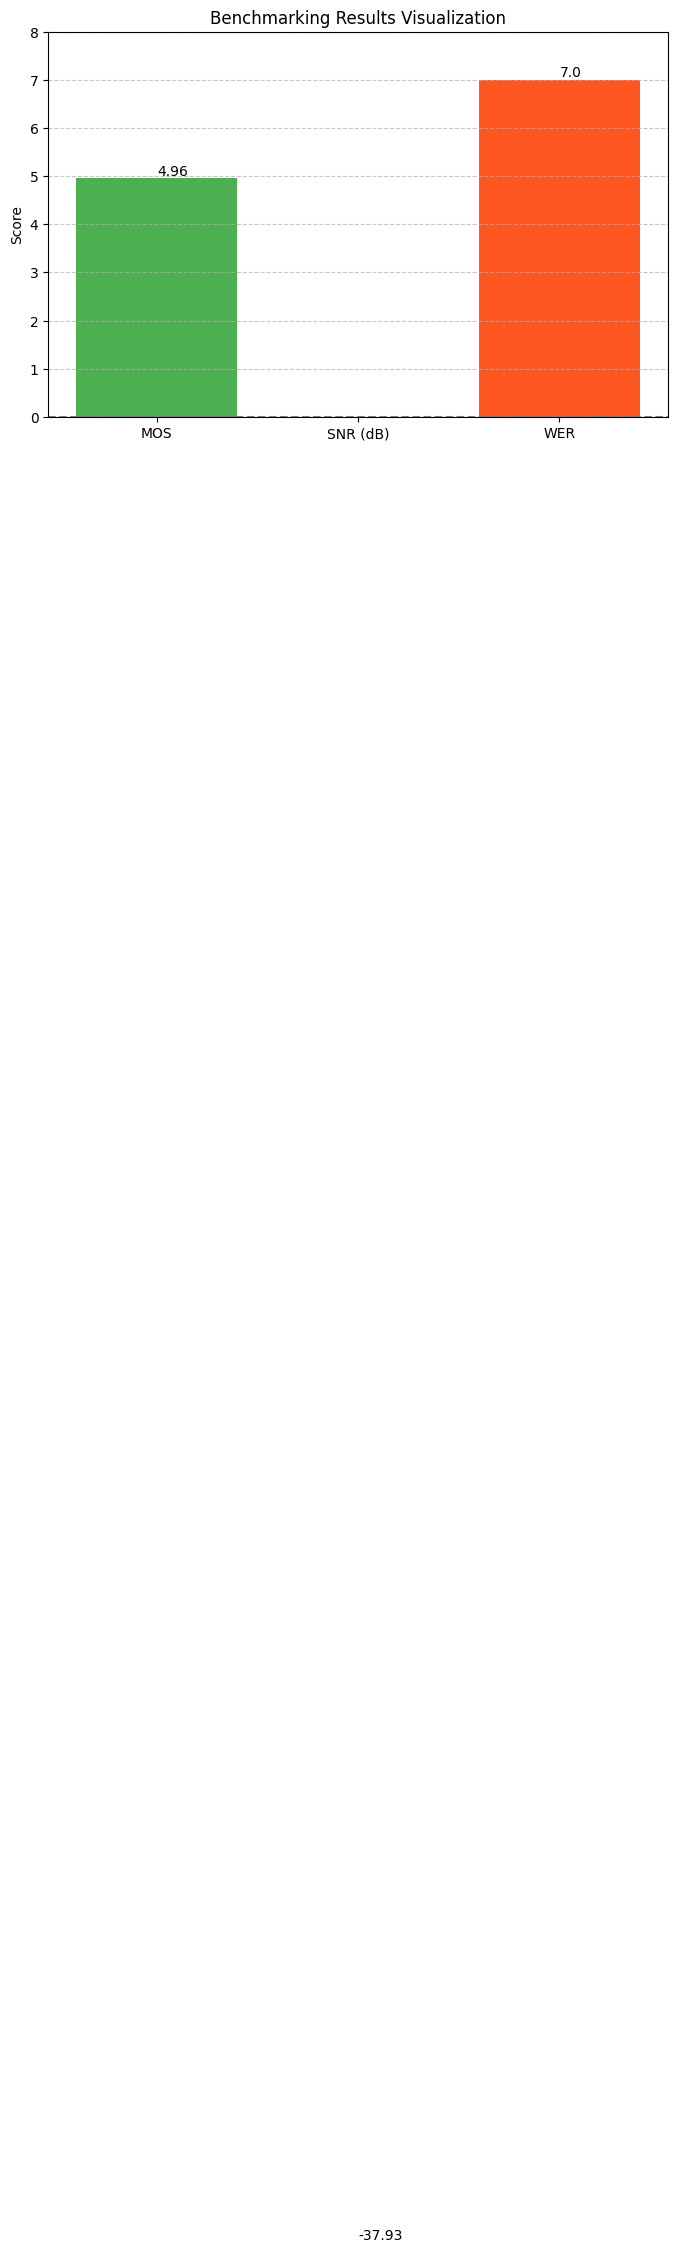

In [ ]:
def visualize_results(mos: float, snr: float, wer: float) -> None:
    """Visualizes the benchmarking results using bar charts."""
    metrics = ['MOS', 'SNR (dB)', 'WER']
    values = [mos, snr, wer]

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, values, color=['#4CAF50', '#2196F3', '#FF5722'])

    # Add data labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

    plt.ylim(0, max(max(values), 5) + 1)  # Set y-axis limit
    plt.title('Benchmarking Results Visualization')
    plt.ylabel('Score')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the visualization function
visualize_results(mos_score, snr_value, wer_value)

In [ ]:
pip install noisereduce

In [ ]:
import soundfile as sf

def reduce_noise(audio_path, sr=22050):
    # Load the audio file
    audio, _ = librosa.load(audio_path, sr=sr)

    # Perform noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    # Save the cleaned audio using soundfile
    sf.write('cleaned_audio.wav', reduced_noise_audio, sr)

    return reduced_noise_audio

# Use the noise-reduced audio for your TTS processing
cleaned_audio = reduce_noise(src_path)
